In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import random
import seaborn as sns
from sklearn import preprocessing

## Loading the dataset

In [2]:
data = pd.read_csv(r"D:/DataScience/ADM/homework4/bank_transactions.csv")

## Inside the dataset

In [3]:
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [4]:
data.shape

(1048567, 9)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


Our analysis will study the groups of clients which are similar among them. From the informations of the dataset we look that there are 1048567 transactions and 9 variables:

1) TransactionID - number (ID) of the transaction (object)

2) CustomerID - number (ID) of the costumer (object)

3) CustomerDOB - customer date of birth (object)

4) CustGender  - customer's gender (object)

5) CustLocation - location - (object)

6) CustAccountBalance - account balance (float64)

7) TransactionDate - day of the transaction (object)

8) TransactionTime - time of the transaction(int64)

9) TransactionAmount (INR) - amount of the transaction in INR (float64) 

The first problem that we encounter is that the customerDOB and the transactionDate are not in the datetime form; also TransactionTime instead is just a number and we need to transform it in datetime.

## Feature Engineering

#### Features: CustomerDOB, transactionDate, TransactionTime; transformation

In [6]:
data.CustomerDOB = pd.to_datetime(data.CustomerDOB)
data.TransactionDate = pd.to_datetime(data.TransactionDate)
data.TransactionTime = data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   TransactionID            1048567 non-null  object        
 1   CustomerID               1048567 non-null  object        
 2   CustomerDOB              1045170 non-null  datetime64[ns]
 3   CustGender               1047467 non-null  object        
 4   CustLocation             1048416 non-null  object        
 5   CustAccountBalance       1046198 non-null  float64       
 6   TransactionDate          1048567 non-null  datetime64[ns]
 7   TransactionTime          1048567 non-null  datetime64[ns]
 8   TransactionAmount (INR)  1048567 non-null  float64       
dtypes: datetime64[ns](3), float64(2), object(4)
memory usage: 72.0+ MB


Now that the 3 variables with problems in dtype are in the correct form let's have a look inside the data to see if the transformation create problems and if there are strange data.

<AxesSubplot:>

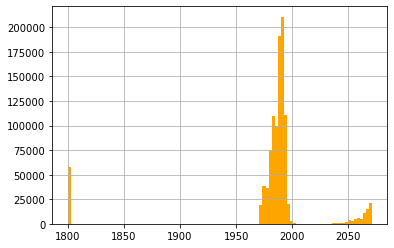

In [8]:
data.CustomerDOB.dt.year.hist(bins=100, color = "orange")

Looking into the histogram it's visible the majority of the distribution in the central block, in addition to this there is a block to the left that contain the customers' date of birth in the year 1800. This is obviously quite impossibile so we drop this data because probably they are NA values. The block to the right contain the customers' date of birth which fall around the year 2050. This happened because changing the dtype from object to datetime we collide in the millennium bag: the years in object are saved with just the last 2 numbers (for example 1950 is saved as 50), so the transformation creates problems because some dates will be saved as 1950 other in 2050. To solve this problem we subtract 100 to the years that come after the year 2005 (so after the end of the central block). Infact to open a bank account in India it's necessary to have at least 10 years, so there cannot be customers born after the year 2005.

<AxesSubplot:>

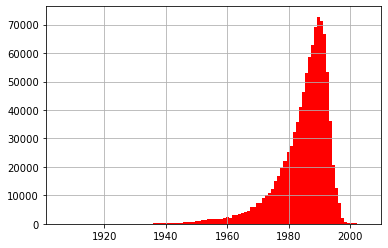

In [9]:
data.loc[data.CustomerDOB.dt.year > 2005, "CustomerDOB"] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
data.drop(data[data.CustomerDOB.dt.year == 1800].index, axis = 0, inplace = True)
data.CustomerDOB.dt.year.hist(bins=100, color = "red")

In [10]:
data.CustomerDOB.dt.year.agg(lambda x: pd.Series.mode(x))

0    1990.0
Name: CustomerDOB, dtype: float64

Now it's visible in the histogram the right distribution of the customers' date of birth, with a peak of 72789 birthdays in 1990.

In [11]:
data.CustomerDOB.dt.year.value_counts()

1990.0    72789
1991.0    71288
1989.0    69238
1992.0    66708
1988.0    63004
          ...  
1920.0        2
1911.0        2
1916.0        2
1925.0        1
1918.0        1
Name: CustomerDOB, Length: 99, dtype: int64

#### NA values

Let's have a look if in the dataset there are some missing values or some false values that need to be drop.

In [12]:
data.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                  227
CustLocation                151
CustAccountBalance         2195
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

The number of values that is NA concerns 4 variables (customerDOB, custGender, custLocation, CustAccountBalance), anyway their number is very small compare to the amount of data that we own (1048567 transactions) so we delete this data.

In [13]:
data.dropna(inplace = True)

In [14]:
data.isna().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

#### CustGender

In [15]:
data['CustGender'].value_counts()

M    712454
F    272868
Name: CustGender, dtype: int64

the Customer's gender can be Male or Female.

#### TransactionAmount (INR)

To semplify the code we change the column name of the variable "TransactionAmount (INR)" in "TransactionAmount".

In [16]:
data.rename(columns = {'TransactionAmount (INR)':'TransactionAmount'}, inplace = True)

#### Duplicated

In [17]:
data[data.duplicated()]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount


There are no duplicated data, so it's possible to say that the dataset is clean.

In [18]:
data.shape

(985322, 9)

The number of transactions now are in total 991228 with 9 variables.

## EDA: Exploratory data analysis

In [19]:
round(data.describe(),1)

,CustAccountBalance,TransactionAmount
count,985322.0,985322.0
mean,106061.2,1452.4
std,817905.4,6139.8
min,0.0,0.0
25%,4582.1,151.0
50%,16006.3,431.0
75%,53759.1,1125.0
max,115035495.1,1560035.0


#### DA FARE EDA

## 2.1.2: FEATURE ENGINEERING

To begin the Feature Engineering we create a new dataset where to put all the new variables created considering the clients.

In [20]:
clients = pd.DataFrame()

It's time now to create the variables:

a) Number of transactions:

In [21]:
numero_transazioni = data.groupby(['CustomerID'])["TransactionID"].count()
clients["Num_transaction"]=numero_transazioni

b) Number of transactions with a balance bigger than 100 USD:

In [22]:
data.loc[data.TransactionAmount <= 100, 'Transaction>100'] = 0
data.loc[data.TransactionAmount > 100, 'Transaction>100'] = 1
clients["Transaction>100"] = data.groupby('CustomerID')['Transaction>100'].sum()

c) Average amount of the transactions:

In [23]:
clients["Average_transaction"]= data.groupby('CustomerID')['TransactionAmount'].mean()

d) Average balance:

In [24]:
clients["Average_balance"]= data.groupby('CustomerID')['CustAccountBalance'].mean()

e) Utilisation (Average difference between the balance and the transaction amount for each customer):

In [25]:
data["difference"]= data['CustAccountBalance']-data['TransactionAmount']
clients["Utilisation"]= data.groupby('CustomerID')['difference'].mean()

f) Most common gender of the customer:

In [26]:
data.loc[data.CustGender == "M", 'GenderNum'] = 0
data.loc[data.CustGender == "F", 'GenderNum'] = 1
clients["GenderNum"]= data.groupby('CustomerID')['GenderNum'].sum()
clients.loc[clients.GenderNum > clients.Num_transaction/2, 'Gender'] = "F"
clients.loc[clients.GenderNum < clients.Num_transaction/2, 'Gender'] = "M"
clients.loc[clients.GenderNum == clients.Num_transaction/2, 'Gender'] = random.choice(["M", "F"])
clients.drop('GenderNum', inplace=True, axis=1)
data.drop('GenderNum', inplace=True, axis=1)

h) Most frequent location of the customer:

In [27]:
location = data.groupby(['CustomerID'])['CustLocation'].agg(pd.Series.mode)

In [28]:
lista=[]
for i in location.index:
    if type(location.loc[i]) == str:
        lista.append(location[i])
    else:
        lista.append(location[i][0])
        

In [29]:
clients["Location"]=lista

## 2.1.3: NEW FEATURES

1) Max transaction:

In [30]:
clients["Max_transaction"]= data.groupby('CustomerID')['TransactionAmount'].max()

2) Min_transaction:

In [31]:
clients["Min_transaction"]= data.groupby('CustomerID')['TransactionAmount'].min()

3) Max_balance:

In [32]:
clients["Max_balance"]= data.groupby('CustomerID')['CustAccountBalance'].max()

4) Min_balance:

In [33]:
clients["Min_balance"]= data.groupby('CustomerID')['CustAccountBalance'].min()

5) Max_Utilisation:

In [34]:
clients["Max_Utilisation"]= data.groupby('CustomerID')['difference'].max()

6) Min_Utilisation:

In [35]:
clients["Min_Utilisation"]= data.groupby('CustomerID')['difference'].min()

7) Balance>10000:

In [36]:
data.loc[data.CustAccountBalance <= 10000, 'Balance>10000'] = 0
data.loc[data.CustAccountBalance > 10000, 'Balance>10000'] = 1
clients["Balance>10000"] = data.groupby('CustomerID')['Balance>10000'].sum()

8) Utilisation<1000:

In [37]:
data.loc[data.difference < 1000, 'Utilisation>1000'] = 0
data.loc[data.difference >= 1000, 'Utilisation<1000'] = 1
clients["Utilisation<1000"] = data.groupby('CustomerID')['Utilisation<1000'].sum()

9) Costumer age Max (in the year 2016, year to which the payment have been done. we are going to take the max value and so the oldest person for each bank account):

In [38]:
data['CustomerAge'] = 2016 - data.CustomerDOB.dt.year
clients["CustomerAge_max"] = data.groupby('CustomerID')['CustomerAge'].max()

10) Costumer age Min (in the year 2016, year to which the payment have been done. we are going to take the min value: the age of the youngest person of each bank account):

In [39]:
clients["CustomerAge_min"] = data.groupby('CustomerID')['CustomerAge'].min()

11) Total Transactions:

In [40]:
clients["Total_transactions"]= data.groupby('CustomerID')['TransactionAmount'].sum()

12) Percentage of transaction > 100 on the total:

In [41]:
clients["%transaction>100"] = (clients["Transaction>100"]/clients["Num_transaction"]*100).round(2)

13) Percentage of Balance > 10000 on the total:

In [42]:
clients["%Balance>10000"] = (clients["Balance>10000"]/clients["Num_transaction"]*100).round(2)

14) Percentage of Utilisation < 1000:

In [43]:
clients["%Utilisation<1000"] = (clients["Utilisation<1000"]/clients["Num_transaction"]*100).round(2)

15) Most common day for transactions:

In [44]:
data['Day'] = data.TransactionDate.dt.dayofweek

In [45]:
data.Day =  data.Day.astype(str)

In [46]:
day = data.groupby(['CustomerID'])['Day'].agg(pd.Series.mode)

In [47]:
lista=[]
for i in day.index:
    if type(day.loc[i]) == str:
        lista.append(day[i])
    else:
        lista.append(day[i][0])

In [48]:
clients["Day"] = lista

16) most common month for transactions:

In [49]:
data['Month'] = data['TransactionDate'].dt.month

In [50]:
data.Month =  data.Month.astype(str)

In [51]:
month = data.groupby(['CustomerID'])['Month'].agg(pd.Series.mode)

In [52]:
lista=[]
for i in month.index:
    if type(month.loc[i]) == str:
        lista.append(month[i])
    else:
        lista.append(month[i][0])

In [53]:
clients["Month"] = lista

17) Time of the day with more transactions:

In [54]:
data['Hour'] = data['TransactionTime'].dt.hour

In [55]:
data.Hour =  data.Hour.astype(str)

In [56]:
hour = data.groupby(['CustomerID'])['Hour'].agg(pd.Series.mode)

In [57]:
lista=[]
for i in hour.index:
    if type(hour.loc[i]) == str:
        lista.append(hour[i])
    else:
        lista.append(hour[i][0])

In [58]:
clients["Hour"] = lista

 18) Minor make the transaction? (yes or no):

In [59]:
clients.loc[clients.CustomerAge_min <18, 'Minor'] = "Yes"
clients.loc[clients.CustomerAge_min >= 18, 'Minor'] = "Not"

19) Time since the first and last transaction:

In [60]:
data["time"] = pd.to_datetime('today') - data.TransactionDate


In [61]:
clients["dist_minimum"] = data.groupby('CustomerID')['time'].min()
clients["dist_maximum"] = data.groupby('CustomerID')['time'].max()
clients["Time"] = clients["dist_maximum"] - clients["dist_minimum"]
clients.drop('dist_minimum', inplace=True, axis=1)
clients.drop('dist_maximum', inplace=True, axis=1)

20) Rich Customer: Is the average_balance >10000 and the transaction been made in one of the ricchest city in India? (Mumbai, New Delhi, Delhi, )?:

In [75]:
clients.loc[(((clients.Location == "MUMBAI") | (clients.Location == "NEW DELHI") | (clients.Location == "DELHI")) & (clients["Average_balance"]>10000)), 'RichCustomer'] = "Yes"
clients.loc[((((clients.Location == "MUMBAI") | (clients.Location == "NEW DELHI") | (clients.Location == "DELHI")) & (clients["Average_balance"]<= 10000)) | ((clients.Location != "MUMBAI") & (clients.Location != "NEW DELHI") & (clients.Location != "DELHI"))), 'RichCustomer'] = "No"

In [77]:
clients.head()

,Num_transaction,Transaction>100,Average_transaction,Average_balance,Utilisation,Gender,Location,Max_transaction,Min_transaction,Max_balance,...,Total_transactions,%transaction>100,%Balance>10000,%Utilisation<1000,Day,Month,Hour,Minor,Time,RichCustomer
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,2,2.0,2553.0,76340.635,73787.635,M,NEW DELHI,4750.0,356.0,120180.54,...,5106.0,100.0,100.0,100.0,0,9,1,Not,18 days,Yes
C1010012,1,1.0,1499.0,24204.490,22705.490,M,MUMBAI,1499.0,1499.0,24204.49,...,1499.0,100.0,100.0,100.0,6,8,20,Not,0 days,Yes
C1010014,2,2.0,727.5,100112.950,99385.450,M,MUMBAI,1205.0,250.0,161848.76,...,1455.0,100.0,100.0,100.0,4,1,15,Not,182 days,Yes
C1010018,1,0.0,30.0,496.180,466.180,F,CHAMPARAN,30.0,30.0,496.18,...,30.0,0.0,0.0,0.0,3,9,17,Not,0 days,No
C1010024,1,1.0,5000.0,87058.650,82058.650,M,KOLKATA,5000.0,5000.0,87058.65,...,5000.0,100.0,100.0,100.0,3,8,14,Not,0 days,No


#### Let's save the dataset!

In [64]:
clients.to_pickle("bank.pkl")

## 2.2 Choose your features (variables)!

#### Normalization

In [65]:
clients = pd.read_pickle("bank.pkl")

In [66]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 839081 entries, C1010011 to C9099956
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype          
---  ------               --------------   -----          
 0   Num_transaction      839081 non-null  int64          
 1   Transaction>100      839081 non-null  float64        
 2   Average_transaction  839081 non-null  float64        
 3   Average_balance      839081 non-null  float64        
 4   Utilisation          839081 non-null  float64        
 5   Gender               839081 non-null  object         
 6   Location             839081 non-null  object         
 7   Max_transaction      839081 non-null  float64        
 8   Min_transaction      839081 non-null  float64        
 9   Max_balance          839081 non-null  float64        
 10  Min_balance          839081 non-null  float64        
 11  Max_Utilisation      839081 non-null  float64        
 12  Min_Utilisation      839081 non-null  float64        


In [67]:
scaler = preprocessing.MinMaxScaler()
clients_norm = scaler.fit_transform(clients)

ValueError: could not convert string to float: 'M'